In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

import os
import json

* Pattern 1 : les uids ayant trop d'activités par minutes
* Pattern 2 : les ips associées à trop de uids
* Pattern 3 : les uids qui enchainent les activités instantanément.

In [2]:
# Import file
filename = "../quickstart/data/logs_100_000.txt"
assert os.path.exists(filename)

cols = ['eventType', 'uid', 'timestamp', 'ip', 'impressionId']

# read file
def read_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    data = {col: [] for col in cols}
    for json_line in lines:
        dline = json.loads(json_line)
        for col in cols:
            data[col].append(dline[col])
    return data

data = read_file(filename)
df = pd.DataFrame(data)

# handle dates
df["timestamp"] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x).strftime("%Y-%m-%d %H-%M-%S"))
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H-%M-%S')

# Min max date
print(f"shape : {df.shape}")
min_time = df.timestamp.min()
max_time = df.timestamp.max()
num_mins = (max_time - min_time).total_seconds() / 60.0

print(f"Min timestamp : {min_time}")
print(f"Max timestamp : {max_time}")
print(f'Delta : {max_time - min_time}')

shape : (165141, 5)
Min timestamp : 2021-05-15 13:05:34
Max timestamp : 2021-05-15 15:32:02
Delta : 0 days 02:26:28


In [3]:
df.timestamp.iloc[0]

Timestamp('2021-05-15 13:05:35')

In [4]:
delta = timedelta(minutes=10)  # Window size in minutes
start_time = min_time
end_time = min_time + delta
bins = [0]
while start_time < max_time:
    bins.append((end_time-min_time).total_seconds())
    start_time += delta
    end_time += delta
df['time_bucket'] = df.timestamp.apply(lambda x: np.digitize((x-min_time).total_seconds(), bins))

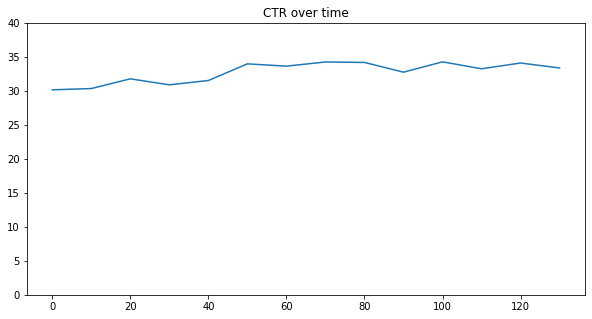

In [5]:
def CTR(df, returned=False, silent=False, meta=False):
    num_clicks = (df['eventType'] == 'click').sum()
    num_displays = (df['eventType'] == 'display').sum()
    ctr = round(100 * num_clicks / num_displays, 4)
    if not silent:
        print(f'CTR : {ctr}% | #clicks={num_clicks} ; #displays={num_displays}')
    if meta:
        return ctr, num_clicks, num_displays
    if returned:
        return ctr
    
    
def CTR_by_window(df, window_size, plot=True):
    delta = timedelta(minutes=window_size)
    start_time = df.timestamp.min()
    end_time = start_time + delta
    max_time = df.timestamp.max()
    ctrs, clicks, displays =  [], [], []
    while end_time < max_time:
        chunk_df = df[(df.timestamp < end_time) & (df.timestamp > start_time)]
        ctr, num_clicks, num_displays = CTR(chunk_df, returned=True, silent=True, meta=True)
        start_time += delta
        end_time += delta
        ctrs.append(ctr)
        clicks.append(num_clicks)
        displays.append(num_displays)
    if plot:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.plot(range(0, len(ctrs)*window_size, window_size), ctrs)
        ax.set_ylim(0, 40)
        ax.set_title('CTR over time');
    else:
        return ctrs, clicks, displays
    
CTR_by_window(df, 10)

In [6]:
print(CTR(df))

CTR : 32.7927% | #clicks=40781 ; #displays=124360
None


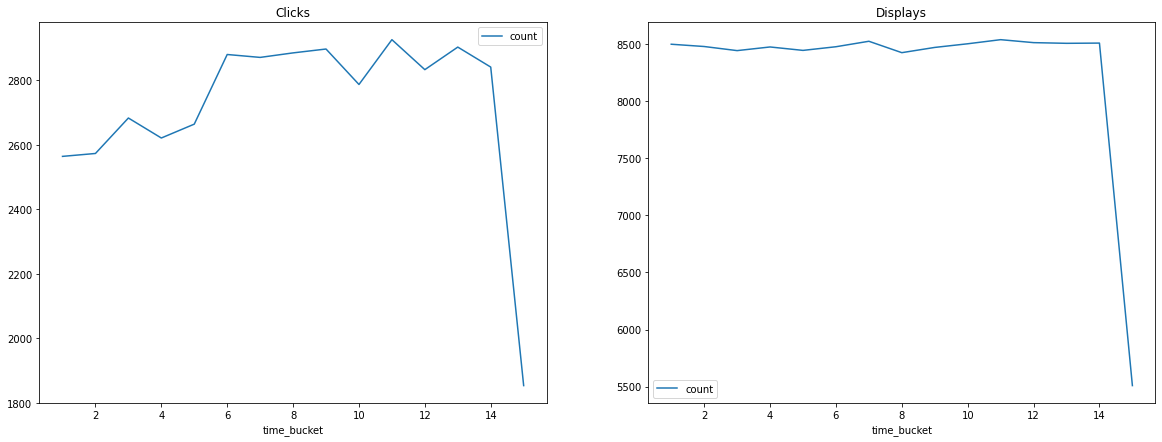

In [7]:
def plot_click_display(df):
    type_counts = df.groupby(['time_bucket', 'eventType']).count().reset_index()[['time_bucket', 'eventType', 'uid']].rename({'uid': 'count'}, axis=1)

    _, ax = plt.subplots(1, 2, figsize=(20, 7))
    type_counts[type_counts.eventType == 'click'].plot(kind='line', x='time_bucket', y='count', ax=ax[0])
    type_counts[type_counts.eventType == 'display'].plot(kind='line', x='time_bucket', y='count', ax=ax[1])
    ax[0].set_title('Clicks')
    ax[1].set_title('Displays');
    
plot_click_display(df)

## Pattern 1

In [8]:
def count_ip_by_window(df_src):
    df = df_src.copy()
    ipxbucket2count = {}
    for bucket in df.time_bucket.unique():
        df_grp = df[df['time_bucket'] == bucket]
        counts = df_grp.ip.value_counts().reset_index().rename({'ip':'ip_count', 'index':'ip'}, axis=1)
        for i, row in counts.iterrows():
            ipxbucket2count[(bucket, row['ip'])] = row['ip_count']
    df['ip_count'] = df.apply(lambda x: ipxbucket2count[(x['time_bucket'], x['ip'])], axis=1)
    return df

df = count_ip_by_window(df)

<AxesSubplot:title={'center':'ip_count'}, xlabel='time_bucket'>

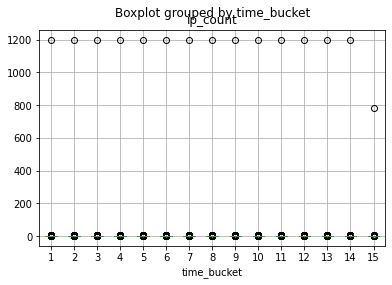

In [10]:
ip_counts = df.groupby(['time_bucket', 'ip']).agg({'ip_count': 'first'}).reset_index()
ip_counts.boxplot(column='ip_count', by='time_bucket')

In [11]:
df_clean = df[df.ip_count < 10].copy()
CTR(df_clean)

CTR : 27.6811% | #clicks=31991 ; #displays=115570


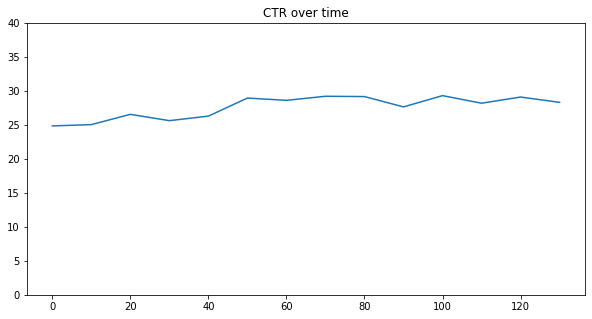

In [12]:
CTR_by_window(df_clean, 10, plot=True)

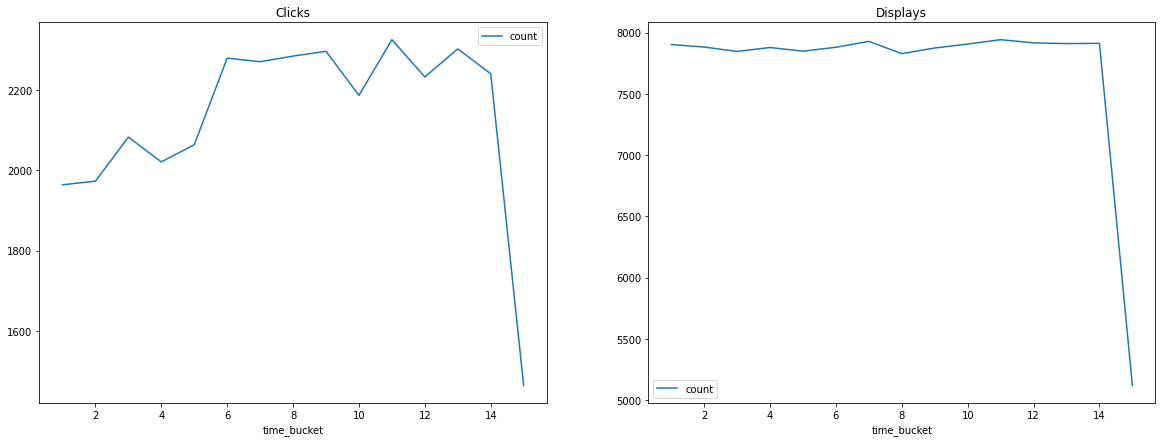

In [13]:
plot_click_display(df_clean)

## Pattern 2

In [32]:
uids = df_clean.groupby(['uid', 'time_bucket']).agg({'eventType':list, 'timestamp':list, 'impressionId':list, 'ip':list}).rename({'eventType':'events', 'timestamp':'timestamps'}, axis=1).reset_index()

In [33]:
def reaction_time_old(x):
    # Click-display reaction time
    history = sorted([(t, event) for t, event in zip(x['timestamps'], x['events'])])
    deltas = []
    for i in range(1, len(history)):
        delta = (history[i][0] - history[i-1][0]).total_seconds()
        names = [history[i-1][1], history[i][1]]
        if 'click' in names and 'display' in names:
            deltas.append(delta)
    return deltas


def reaction_time(x):
    history = sorted([(t, event, ip, imp_id) for t, event, ip, imp_id in zip(x['timestamps'], x['events'], x['ip'], x['impressionId'])])
    deltas = []
    for i in range(1, len(history)):
        if history[i][1] == 'click':
            for j in range(0, i):
                if history[j][1] == 'display' and history[i][2] == history[j][2] and history[i][3] == history[j][3]:
                    delta = (history[i][0] - history[j][0]).total_seconds()
                    deltas.append(delta)
                    break
    return deltas

uids['reaction_times'] = uids.apply(lambda x: reaction_time(x), axis=1)

In [34]:
uids

,uid,time_bucket,events,timestamps,impressionId,ip,reaction_times
0,00057b36-3574-4d7e-b0d0-1703ae4e3fe1,10,[display],[2021-05-15 14:37:34],[fba86307-9cee-448e-a036-0a99fe2aec55],[86.235.194.228],[]
1,000a92c5-643a-4e5a-8f4e-bc8f4be28156,11,[display],[2021-05-15 14:49:38],[7f4fe116-a9e2-4d0f-944c-b65cbde71482],[211.158.82.116],[]
2,000ac623-ef3b-4c3c-9d12-01367b8f0b3b,13,[display],[2021-05-15 15:15:01],[65bfacb0-5a55-4783-aea0-ac6712235c6a],[215.94.6.149],[]
3,000af57e-5a84-48fa-95a8-ba5e5ba68867,10,[display],[2021-05-15 14:42:49],[49aa202e-bb15-4608-a299-252b83eb44cd],[83.122.187.116],[]
4,000bbdc5-f95b-4504-8b93-5d5a124e5716,10,[display],[2021-05-15 14:38:06],[a3372174-ef48-4e66-ba40-1d60ed48e7d0],[41.2.107.250],[]
...,...,...,...,...,...,...,...
64223,fffcab17-aa90-4fd1-92a1-a9de23c84eee,2,[display],[2021-05-15 13:20:35],[778625af-0a8a-4916-93af-2379d8a46fe7],[88.105.39.26],[]
64224,fffd3aeb-4383-4266-96fb-eb6b95d0b477,1,[display],[2021-05-15 13:11:05],[b56f5551-3418-4916-b9ae-4916f09aa1f2],[247.138.220.207],[]
64225,fffe25c1-bb51-4bc3-99e9-f9f851775a4a,8,[display],[2021-05-15 14:20:09],[875147f8-8f9a-4c91-8d0d-b6c9d49a368f],[48.98.32.135],[]
64226,fffe25c1-bb51-4bc3-99e9-f9f851775a4a,11,[click],[2021-05-15 14:45:40],[875147f8-8f9a-4c91-8d0d-b6c9d49a368f],[48.98.32.135],[]


In [35]:
uids['min_reaction_time'] = uids.reaction_times.apply(lambda x: min(x) if len(x) > 0 else None)
uids['avg_reaction_time'] = uids.reaction_times.apply(lambda x: sum(x) / len(x) if len(x) > 0 else None)

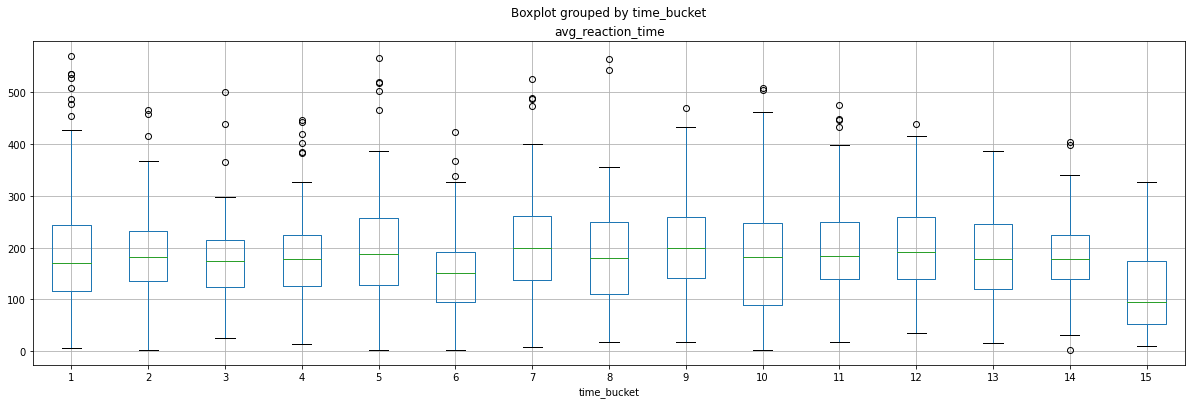

In [16]:
uids.boxplot(column='avg_reaction_time', by='time_bucket', figsize=(20, 6));

<AxesSubplot:xlabel='min_reaction_time', ylabel='Count'>

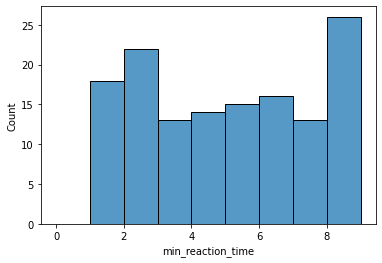

In [102]:
sns.histplot(uids.min_reaction_time, bins=np.arange(0, 10, 1))

In [30]:
uids_to_remove = set(uids[(uids.min_reaction_time < 1)].uid)

In [31]:
uids_to_remove


set()

In [17]:
df_clean['opposite_event'] = df_clean.eventType.apply(lambda x: 'click' if x == 'display' else 'display')
df_clean_2 = df_clean.merge(df_clean[['eventType', 'timestamp', 'uid']], 
                            left_on=['opposite_event', 'timestamp', 'uid'], 
                            right_on=['eventType', 'timestamp', 'uid'], 
                            how='left').rename({'eventType_x': 'eventType'}, axis=1)
df_clean_2 = df_clean_2[df_clean_2.eventType_y.isnull()]

In [18]:
df_clean_2[df_clean_2['eventType_y'].notnull()]

,eventType,uid,timestamp,ip,impressionId,time_bucket,ip_count,opposite_event,eventType_y


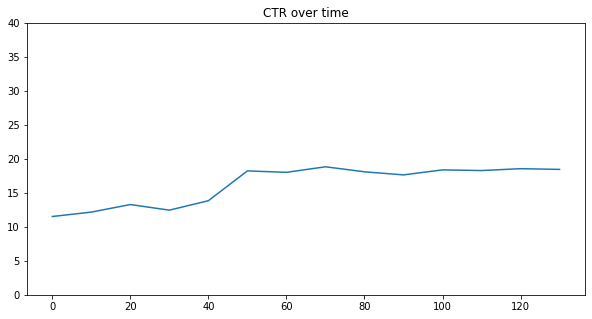

In [28]:
CTR_by_window(df_clean[~df_clean.uid.isin(uids_to_remove)], window_size=10)

In [29]:
CTR(df_clean[~df_clean.uid.isin(uids_to_remove)])

CTR : 16.3615% | #clicks=11321 ; #displays=69193


CTR : 27.6748% | #clicks=31981 ; #displays=115560
None


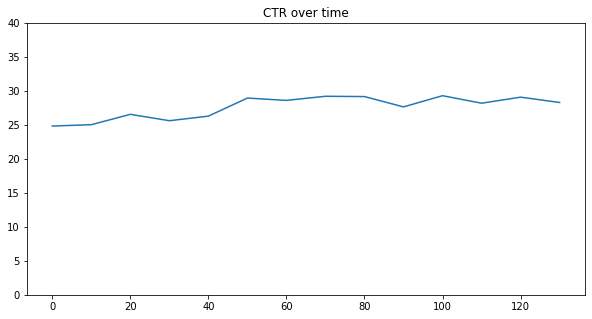

In [81]:
print(CTR(df_clean_2))
CTR_by_window(df_clean_2, window_size=10)

## Pattern 3

### 1. CTR per uid and num_clicks

In [130]:
uidxctr = df_clean_2.groupby(['time_bucket', 'uid']).agg({'eventType': list, 'impressionId':list, 'ip':list}).reset_index().rename({'eventType':'events'}, axis=1)
uidxctr['ctr_uid'] = uidxctr.events.apply(lambda x: x.count('click') / max(1, x.count('display') ))
uidxctr['num_clicks'] = uidxctr.events.apply(lambda x: x.count('click'))

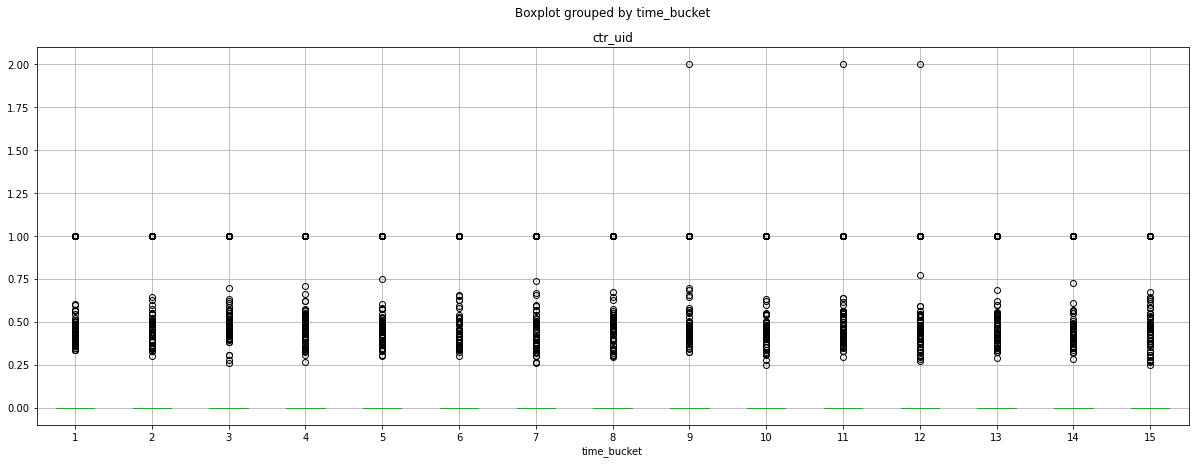

In [131]:
uidxctr.boxplot(column='ctr_uid', by='time_bucket', figsize=(20, 7));

In [132]:
uidxctr['num_events'] = uidxctr['events'].apply(lambda x: len(x))

(0.0, 1.0)

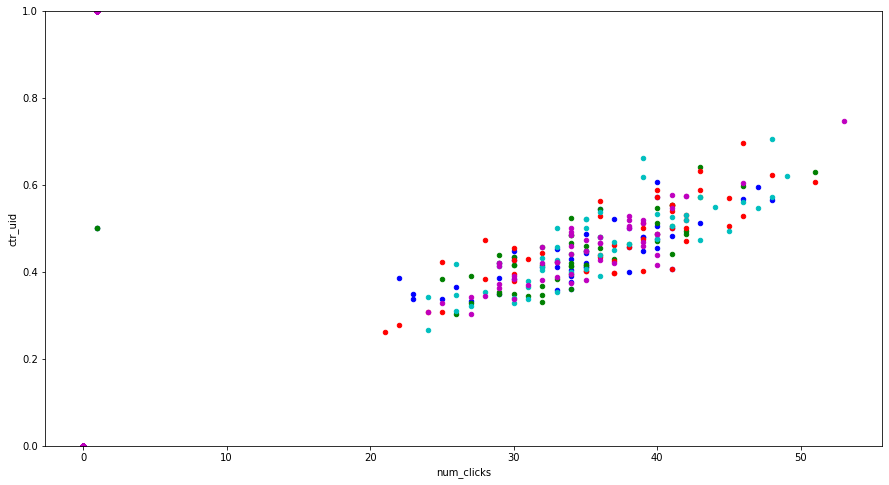

In [133]:
_, ax = plt.subplots(1, 1, figsize=(15, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

for i in uidxctr.time_bucket.unique():
    uidxctr[uidxctr['time_bucket'] == i].plot(kind='scatter', x='num_clicks', y='ctr_uid', ax=ax, color=colors[i-1])
    if i == 5:
        break
ax.set_ylim(0, 1)

In [110]:
uidxctr["num_ip"] = uidxctr.ip.apply(lambda x: len(set(x)))

<AxesSubplot:title={'center':'num_ip'}, xlabel='time_bucket'>

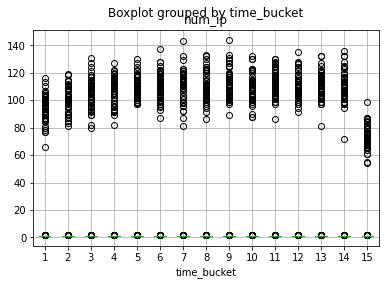

In [111]:
uidxctr.boxplot(column='num_ip', by='time_bucket')

<AxesSubplot:xlabel='num_ip', ylabel='num_clicks'>

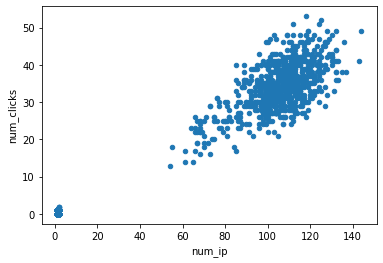

In [112]:
uidxctr[uidxctr['time_bucket'] != 30].plot(kind='scatter', x='num_ip', y='num_clicks')

In [118]:
df_clean_3 = df_clean_2.merge(uidxctr[['uid', 'time_bucket', 'num_clicks', 'num_ip']], on=['uid', 'time_bucket'], how='left')
df_clean_3 = df_clean_3[df_clean_3['num_ip'] < 40].copy()

In [119]:
CTR(df_clean_3)

CTR : 10.8073% | #clicks=6245 ; #displays=57785


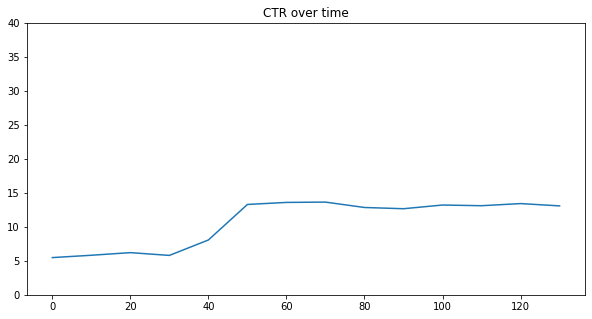

In [120]:
CTR_by_window(df_clean_3, window_size=10)

In [54]:
removed_uids = set(df_clean_2.uid) - set(df_clean_3.uid)
removed_df = df_clean_2[df_clean_2.uid.isin(removed_uids)].copy()

In [63]:
removed_df.shape[0] / df_clean_2.shape[0]

0.46858212022849366

In [75]:
uids = removed_df.groupby(["time_bucket", "uid"]).agg({'timestamp':list, 'ip':list, 'eventType':list, 'impressionId':list}).reset_index()

In [76]:
uids['num_events'] = uids.eventType.apply(lambda x: len(x))
uids['num_clicks'] = uids.eventType.apply(lambda x: x.count('click'))
uids['num_displays'] = uids.eventType.apply(lambda x: x.count('display'))
uids['ctr'] = uids.eventType.apply(lambda x: x.count('click')/x.count('display'))

In [77]:
uids.iloc[0]

time_bucket                                                     1
uid                          05ca6fce-5814-4cf5-94b6-d0b108b0695f
timestamp       [2021-05-15 13:05:56, 2021-05-15 13:05:37, 202...
ip              [206.32.74.0, 23.209.4.107, 177.78.28.219, 206...
eventType       [click, display, display, display, display, di...
impressionId    [c8c5cc9c-fcf1-419d-8235-42cc341f1e35, a34a029...
num_events                                                     88
num_clicks                                                     24
num_displays                                                   64
ctr                                                         0.375
Name: 0, dtype: object

In [79]:
for i, t, e, ip in zip(uids.iloc[0].impressionId, uids.iloc[0].timestamp, uids.iloc[0].eventType, uids.iloc[0].ip):
    print(i, t, e, ip)

c8c5cc9c-fcf1-419d-8235-42cc341f1e35 2021-05-15 13:05:56 click 206.32.74.0
a34a029b-6efe-46aa-830c-89567366ac69 2021-05-15 13:05:37 display 23.209.4.107
6cce3f80-5b22-4b50-8068-deba348adcf3 2021-05-15 13:05:40 display 177.78.28.219
c8c5cc9c-fcf1-419d-8235-42cc341f1e35 2021-05-15 13:05:41 display 206.32.74.0
b6731233-f4da-41f7-91ee-892d2a69633a 2021-05-15 13:05:46 display 158.141.11.37
fc8c4e7a-0461-412a-a836-f2c06af84866 2021-05-15 13:05:52 display 121.153.94.119
2c36b8ad-e515-4a2b-be66-f0b012261210 2021-05-15 13:06:03 display 199.188.69.146
14537c0b-d6b2-4d22-860f-4e6b0e182b09 2021-05-15 13:06:08 display 83.184.143.171
d3326ea4-6c57-4628-b47a-ab77c4c876f5 2021-05-15 13:06:15 display 170.99.174.185
fcd07b9d-16ae-46c9-9f45-fe58a7766d8a 2021-05-15 13:06:19 display 128.172.88.157
312dfce1-aebb-4c47-b611-fc9b75cba506 2021-05-15 13:06:22 display 42.54.127.52
e5977646-8662-4aef-86f8-9c35541e270d 2021-05-15 13:06:27 display 172.40.79.148
1185589d-9b28-47ee-adc2-6d092fbdec75 2021-05-15 13:06:3